# Trader Performance vs Market Sentiment
## Hyperliquid Trader Behavior Under Bitcoin Fear/Greed Regimes

This notebook analyzes how Bitcoin market sentiment (Fear & Greed Index) relates to trader behavior and performance on Hyperliquid DEX. We cover:
- **Part A** -- Data preparation & feature engineering
- **Part B** -- Statistical analysis & trader segmentation
- **Part C** -- Actionable strategy recommendations
- **Bonus** -- Predictive modeling & clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../output/charts')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

---
# Part A -- Data Preparation
## A1. Load & Profile Datasets

In [ ]:
df_sentiment = pd.read_csv(DATA_DIR / 'sentiment_data.csv')
df_trades = pd.read_csv(DATA_DIR / 'trader_data.csv')

print('=== Sentiment Dataset ===')
print(f'Shape: {df_sentiment.shape}')
print(f'Columns: {list(df_sentiment.columns)}')
print(f'\nDtypes:\n{df_sentiment.dtypes}')
print(f'\nMissing values:\n{df_sentiment.isnull().sum()}')
print(f'Duplicates: {df_sentiment.duplicated().sum()}')
df_sentiment.head()

=== Sentiment Dataset ===
Shape: (2644, 4)
Columns: ['timestamp', 'value', 'classification', 'date']

Dtypes:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicates: 0


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
print('=== Trader Dataset ===')
print(f'Shape: {df_trades.shape}')
print(f'Columns: {list(df_trades.columns)}')
print(f'\nDtypes:\n{df_trades.dtypes}')
print(f'\nMissing values:\n{df_trades.isnull().sum()}')
print(f'Duplicates: {df_trades.duplicated().sum()}')
df_trades.head()

=== Trader Dataset ===
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Dtypes:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order I

Duplicates: 0


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
print('Sentiment classification distribution:')
print(df_sentiment['classification'].value_counts())
print(f'\nDate range: {df_sentiment["date"].min()} to {df_sentiment["date"].max()}')

print(f'\n\nUnique trader accounts: {df_trades["Account"].nunique()}')
print(f'Unique coins traded: {df_trades["Coin"].nunique()}')
print(f'\nTop 10 traded coins:')
print(df_trades['Coin'].value_counts().head(10))
print(f'\nTrade direction distribution:')
print(df_trades['Direction'].value_counts())

Sentiment classification distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Date range: 2018-02-01 to 2025-05-02


Unique trader accounts: 32
Unique coins traded: 246

Top 10 traded coins:
Coin
HYPE         68005
@107         29992
BTC          26064
ETH          11158
SOL          10691
FARTCOIN      4650
MELANIA       4428
PURR/USDC     2774
WLD           1983
SUI           1979
Name: count, dtype: int64

Trade direction distribution:
Direction
Open Long                    49895
Close Long                   48678
Open Short                   39741
Close Short                  36013
Sell                         19902
Buy                          16716
Spot Dust Conversion           142
Short > Long                    70
Long > Short                    57
Auto-Deleveraging                8
Liquidated Isolated Short        1
Settlement                       1
Name: count, dtype:

## A2. Clean & Convert

In [ ]:
# --- Sentiment: parse date ---
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment = df_sentiment.sort_values('date').reset_index(drop=True)

# Binary and ternary sentiment labels
def map_sentiment_binary(cls):
    if cls in ('Fear', 'Extreme Fear'):
        return 'Fear'
    elif cls in ('Greed', 'Extreme Greed'):
        return 'Greed'
    return 'Neutral'

df_sentiment['sentiment_binary'] = df_sentiment['classification'].map(map_sentiment_binary)

print('Binary sentiment distribution:')
print(df_sentiment['sentiment_binary'].value_counts())
print(f'\nSentiment date range: {df_sentiment["date"].min().date()} to {df_sentiment["date"].max().date()}')
df_sentiment.head()

Binary sentiment distribution:
sentiment_binary
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64

Sentiment date range: 2018-02-01 to 2025-05-02


,timestamp,value,classification,date,sentiment_binary
0,1517463000,30,Fear,2018-02-01,Fear
1,1517549400,15,Extreme Fear,2018-02-02,Fear
2,1517635800,40,Fear,2018-02-03,Fear
3,1517722200,24,Extreme Fear,2018-02-04,Fear
4,1517808600,11,Extreme Fear,2018-02-05,Fear


In [ ]:
# --- Trader data: standardize columns, parse timestamps ---
df_trades.columns = df_trades.columns.str.strip().str.lower().str.replace(' ', '_')

df_trades['datetime'] = pd.to_datetime(df_trades['timestamp'], unit='ms')
df_trades['date'] = df_trades['datetime'].dt.normalize()

print(f'Trader data date range: {df_trades["date"].min().date()} to {df_trades["date"].max().date()}')
df_trades.head(3)

Trader data date range: 2023-03-28 to 2025-06-15


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,datetime,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27


## A3. Merge Datasets by Date

In [ ]:
df = df_trades.merge(
    df_sentiment[['date', 'value', 'classification', 'sentiment_binary']],
    on='date',
    how='inner'
)

print(f'Merged dataset shape: {df.shape}')
print(f'Date range after merge: {df["date"].min().date()} to {df["date"].max().date()}')
print(f'Rows dropped (no sentiment match): {len(df_trades) - len(df)}')
print(f'\nSentiment distribution in merged data:')
print(df['sentiment_binary'].value_counts())

Merged dataset shape: (184263, 21)
Date range after merge: 2023-03-28 to 2025-02-19
Rows dropped (no sentiment match): 26961

Sentiment distribution in merged data:
sentiment_binary
Fear       133871
Greed       43251
Neutral      7141
Name: count, dtype: int64


## A4. Engineer Daily Metrics

In [ ]:
def compute_daily_metrics(group):
    pnl = group['closed_pnl']
    size = group['size_usd']
    direction = group['direction']

    long_count = direction.str.contains('Long', case=False, na=False).sum()
    short_count = direction.str.contains('Short', case=False, na=False).sum()

    cumulative_pnl = pnl.cumsum()
    running_max = cumulative_pnl.cummax()
    drawdown = (cumulative_pnl - running_max).min()

    closing_trades = pnl[pnl != 0]

    return pd.Series({
        'daily_pnl': pnl.sum(),
        'win_rate': (closing_trades > 0).mean() if len(closing_trades) > 0 else np.nan,
        'avg_trade_size': size.mean(),
        'trade_count': len(group),
        'long_count': long_count,
        'short_count': short_count,
        'long_short_ratio': long_count / short_count if short_count > 0 else np.nan,
        'avg_fee': group['fee'].mean(),
        'max_drawdown': drawdown,
        'total_volume': size.sum(),
    })

daily = df.groupby(['account', 'date']).apply(compute_daily_metrics, include_groups=False).reset_index()

# Re-attach sentiment columns
daily = daily.merge(
    df_sentiment[['date', 'value', 'classification', 'sentiment_binary']],
    on='date',
    how='left'
)

print(f'Daily metrics shape: {daily.shape}')
print(f'Columns: {list(daily.columns)}')
daily.head()

Daily metrics shape: (77, 15)
Columns: ['account', 'date', 'daily_pnl', 'win_rate', 'avg_trade_size', 'trade_count', 'long_count', 'short_count', 'long_short_ratio', 'avg_fee', 'max_drawdown', 'total_volume', 'value', 'classification', 'sentiment_binary']


,account,date,daily_pnl,win_rate,avg_trade_size,trade_count,long_count,short_count,long_short_ratio,avg_fee,max_drawdown,total_volume,value,classification,sentiment_binary
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,0.086331,14810.891818,462.0,0.0,462.0,0.000000,2.408865,-327505.900056,6842632.02,74,Greed,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,0.854363,16345.241940,3356.0,571.0,2786.0,0.204953,1.874975,-99853.030802,54854631.95,44,Fear,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,1.000000,2492.749906,320.0,34.0,0.0,NaN,0.631772,0.000000,797679.97,74,Greed,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,0.797613,1693.351684,3533.0,340.0,464.0,0.732759,0.471247,-22423.106662,5982611.50,44,Fear,Fear
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,0.000000,6070.200000,5.0,0.0,5.0,0.000000,2.039586,-1.000000,30351.00,50,Neutral,Neutral


In [ ]:
print('Daily metrics summary statistics:')
daily[['daily_pnl', 'win_rate', 'avg_trade_size', 'trade_count',
       'long_short_ratio', 'max_drawdown', 'total_volume']].describe().round(2)

Daily metrics summary statistics:


,daily_pnl,win_rate,avg_trade_size,trade_count,long_short_ratio,max_drawdown,total_volume
count,77.00,72.00,77.00,77.00,51.00,77.00,7.700000e+01
mean,132795.45,0.82,5565.93,2393.03,25.64,-19977.87,1.144042e+07
std,311787.97,0.24,6663.91,4227.89,172.69,47804.02,2.553967e+07
min,-327505.90,0.00,34.92,2.00,0.00,-327505.90,2.095000e+02
25%,1793.16,0.80,1684.20,190.00,0.10,-14505.51,5.322075e+05
50%,36993.37,0.90,2936.20,763.00,0.50,-867.79,2.508697e+06
75%,116412.25,0.99,6742.72,3356.00,1.39,0.00,1.073817e+07
max,1927735.72,1.00,31941.66,26651.00,1234.50,0.00,1.635148e+08


---
# Part B -- Analysis
## B1. Performance vs Sentiment

In [ ]:
perf_by_sentiment = daily.groupby('sentiment_binary')[['daily_pnl', 'win_rate', 'max_drawdown']].agg(
    ['mean', 'median', 'std', 'count']
).round(2)
print('Performance metrics by sentiment regime:')
perf_by_sentiment

Performance metrics by sentiment regime:


daily_pnl                            win_rate               \
                       mean    median        std count     mean median   std   
sentiment_binary                                                               
Fear              209372.66  81389.68  380423.91    32     0.87   0.90  0.13   
Greed              90988.70  20925.51  264805.42    37     0.85   0.95  0.23   
Neutral            19842.80     -0.42   57227.79     8     0.53   0.56  0.41   

                       max_drawdown                           
                 count         mean   median       std count  
sentiment_binary                                              
Fear                32    -27333.56 -6867.63  39457.61    32  
Greed               32    -13649.74  -128.00  55707.40    37  
Neutral              8    -19822.70 -4378.46  38693.80     8

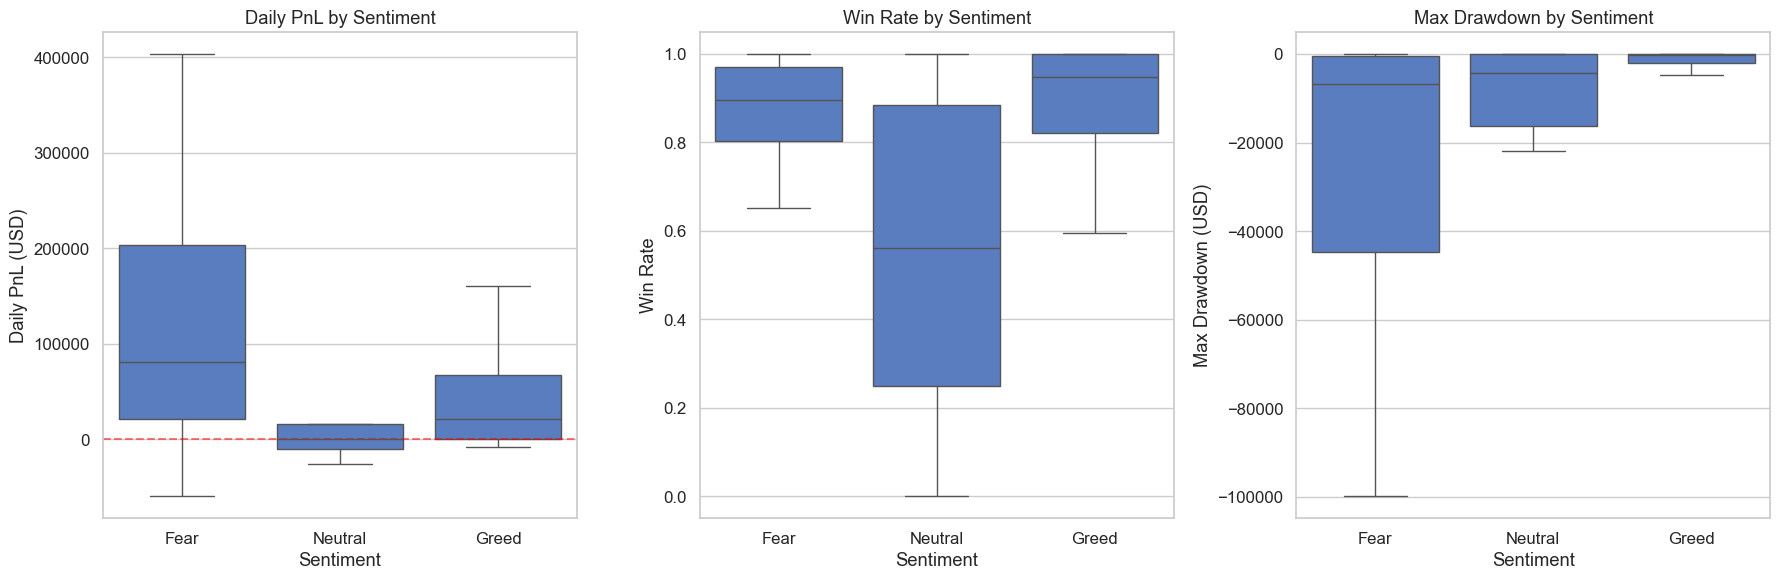

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

order = ['Fear', 'Neutral', 'Greed']

sns.boxplot(data=daily, x='sentiment_binary', y='daily_pnl', order=order, ax=axes[0],
            showfliers=False)
axes[0].set_title('Daily PnL by Sentiment')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Daily PnL (USD)')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)

sns.boxplot(data=daily, x='sentiment_binary', y='win_rate', order=order, ax=axes[1],
            showfliers=False)
axes[1].set_title('Win Rate by Sentiment')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Win Rate')

sns.boxplot(data=daily, x='sentiment_binary', y='max_drawdown', order=order, ax=axes[2],
            showfliers=False)
axes[2].set_title('Max Drawdown by Sentiment')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Max Drawdown (USD)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'performance_vs_sentiment.png', bbox_inches='tight')
plt.show()

In [ ]:
# Statistical tests: Mann-Whitney U for Fear vs Greed
fear_pnl = daily[daily['sentiment_binary'] == 'Fear']['daily_pnl'].dropna()
greed_pnl = daily[daily['sentiment_binary'] == 'Greed']['daily_pnl'].dropna()

stat_pnl, p_pnl = stats.mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
print(f'Mann-Whitney U test (Daily PnL: Fear vs Greed):')
print(f'  U-statistic = {stat_pnl:.0f}, p-value = {p_pnl:.4f}')
print(f'  Fear mean PnL = ${fear_pnl.mean():.2f}, Greed mean PnL = ${greed_pnl.mean():.2f}')
print(f'  Significant at 5%: {"Yes" if p_pnl < 0.05 else "No"}')

fear_wr = daily[daily['sentiment_binary'] == 'Fear']['win_rate'].dropna()
greed_wr = daily[daily['sentiment_binary'] == 'Greed']['win_rate'].dropna()
stat_wr, p_wr = stats.mannwhitneyu(fear_wr, greed_wr, alternative='two-sided')
print(f'\nMann-Whitney U test (Win Rate: Fear vs Greed):')
print(f'  U-statistic = {stat_wr:.0f}, p-value = {p_wr:.4f}')
print(f'  Fear mean WR = {fear_wr.mean():.3f}, Greed mean WR = {greed_wr.mean():.3f}')

fear_dd = daily[daily['sentiment_binary'] == 'Fear']['max_drawdown'].dropna()
greed_dd = daily[daily['sentiment_binary'] == 'Greed']['max_drawdown'].dropna()
stat_dd, p_dd = stats.mannwhitneyu(fear_dd, greed_dd, alternative='two-sided')
print(f'\nMann-Whitney U test (Drawdown: Fear vs Greed):')
print(f'  U-statistic = {stat_dd:.0f}, p-value = {p_dd:.4f}')
print(f'  Fear mean DD = ${fear_dd.mean():.2f}, Greed mean DD = ${greed_dd.mean():.2f}')

Mann-Whitney U test (Daily PnL: Fear vs Greed):
  U-statistic = 798, p-value = 0.0134
  Fear mean PnL = $209372.66, Greed mean PnL = $90988.70
  Significant at 5%: Yes

Mann-Whitney U test (Win Rate: Fear vs Greed):
  U-statistic = 437, p-value = 0.3140
  Fear mean WR = 0.869, Greed mean WR = 0.846

Mann-Whitney U test (Drawdown: Fear vs Greed):
  U-statistic = 307, p-value = 0.0005
  Fear mean DD = $-27333.56, Greed mean DD = $-13649.74


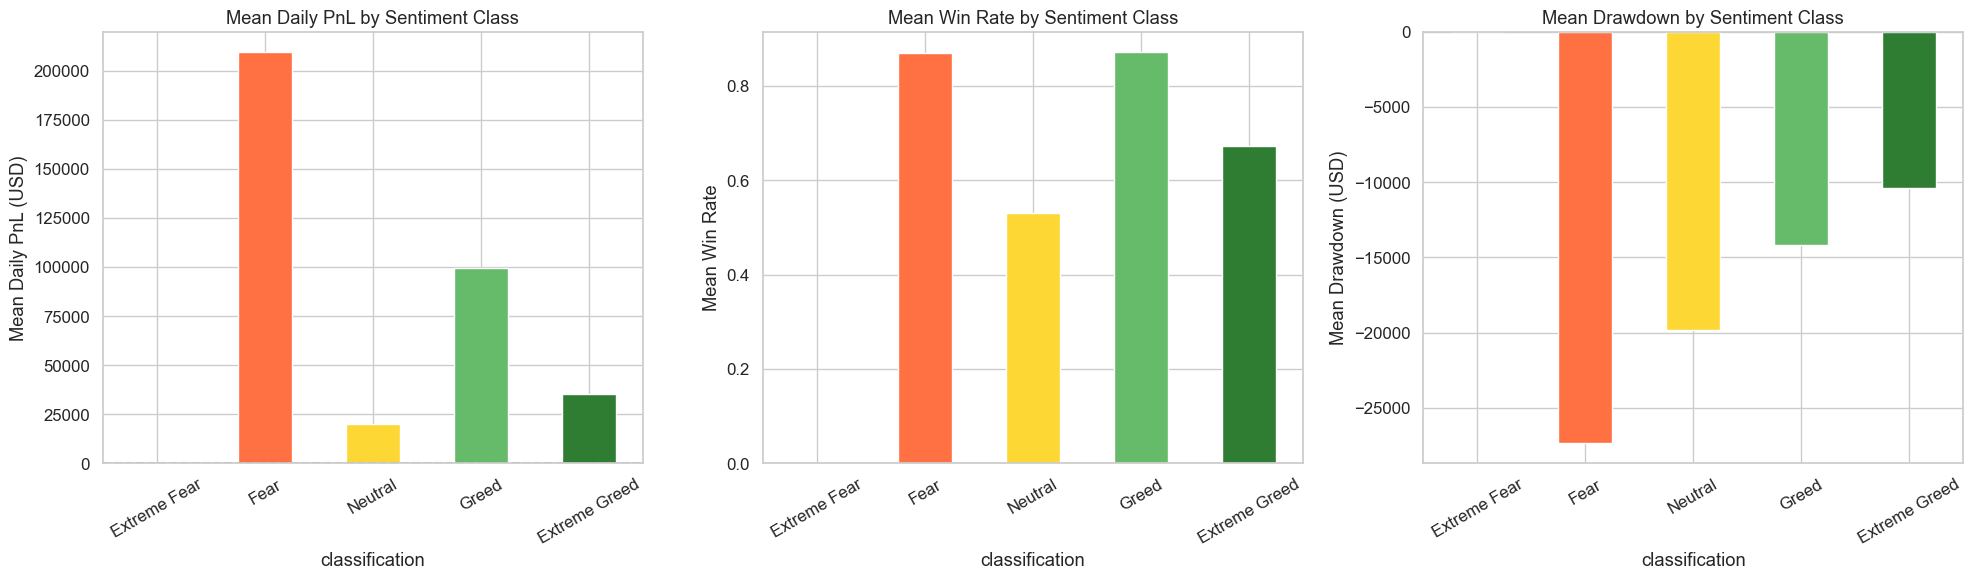

,mean_pnl,mean_wr,mean_dd
classification,,,
Extreme Fear,NaN,NaN,NaN
Fear,209372.66,0.87,-27333.56
Neutral,19842.80,0.53,-19822.70
Greed,99675.52,0.87,-14160.50
Extreme Greed,35393.10,0.67,-10380.88


In [ ]:
# 5-class breakdown
class_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

perf_5class = daily.groupby('classification').agg(
    mean_pnl=('daily_pnl', 'mean'),
    mean_wr=('win_rate', 'mean'),
    mean_dd=('max_drawdown', 'mean'),
).reindex(class_order)

perf_5class['mean_pnl'].plot.bar(ax=axes[0], color=['#d32f2f','#ff7043','#fdd835','#66bb6a','#2e7d32'])
axes[0].set_title('Mean Daily PnL by Sentiment Class')
axes[0].set_ylabel('Mean Daily PnL (USD)')
axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].tick_params(axis='x', rotation=30)

perf_5class['mean_wr'].plot.bar(ax=axes[1], color=['#d32f2f','#ff7043','#fdd835','#66bb6a','#2e7d32'])
axes[1].set_title('Mean Win Rate by Sentiment Class')
axes[1].set_ylabel('Mean Win Rate')
axes[1].tick_params(axis='x', rotation=30)

perf_5class['mean_dd'].plot.bar(ax=axes[2], color=['#d32f2f','#ff7043','#fdd835','#66bb6a','#2e7d32'])
axes[2].set_title('Mean Drawdown by Sentiment Class')
axes[2].set_ylabel('Mean Drawdown (USD)')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'performance_5class.png', bbox_inches='tight')
plt.show()
perf_5class.round(2)

## B2. Behavioral Shifts Across Sentiment Regimes

In [ ]:
behavior_cols = ['trade_count', 'avg_trade_size', 'long_short_ratio', 'total_volume']
behavior_by_sentiment = daily.groupby('sentiment_binary')[behavior_cols].agg(['mean', 'median']).round(2)
print('Behavioral metrics by sentiment regime:')
behavior_by_sentiment

Behavioral metrics by sentiment regime:


trade_count         avg_trade_size          long_short_ratio  \
                        mean  median           mean   median             mean   
sentiment_binary                                                                
Fear                 4183.47  2763.5        5926.52  3207.89            47.83   
Greed                1168.95   283.0        5637.30  2786.43             0.65   
Neutral               892.62   164.5        3793.44  2317.59             0.79   

                        total_volume              
                 median         mean      median  
sentiment_binary                                  
Fear               0.73  22004952.91  7341059.78  
Greed              0.12   4186768.71   810078.52  
Neutral            0.50   2730404.29   372722.08

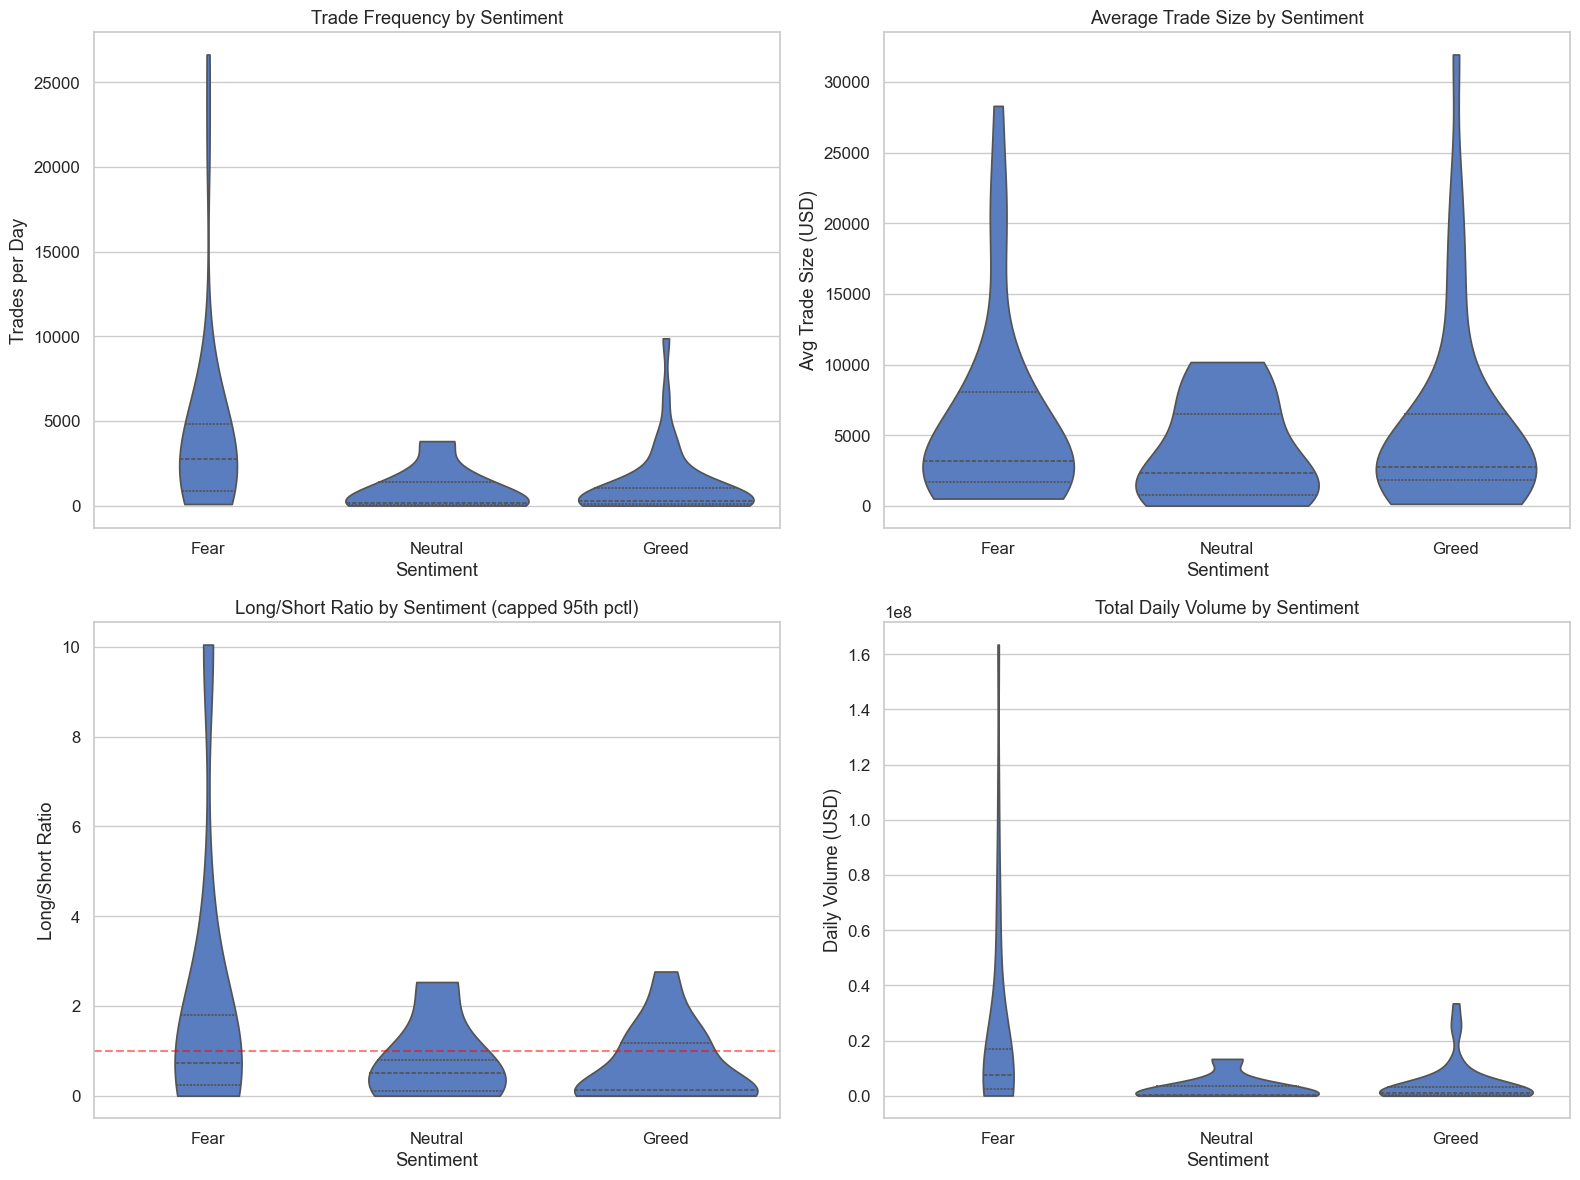

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.violinplot(data=daily, x='sentiment_binary', y='trade_count', order=order,
               ax=axes[0, 0], cut=0, inner='quartile')
axes[0, 0].set_title('Trade Frequency by Sentiment')
axes[0, 0].set_ylabel('Trades per Day')

sns.violinplot(data=daily, x='sentiment_binary', y='avg_trade_size', order=order,
               ax=axes[0, 1], cut=0, inner='quartile')
axes[0, 1].set_title('Average Trade Size by Sentiment')
axes[0, 1].set_ylabel('Avg Trade Size (USD)')

ls_capped = daily['long_short_ratio'].clip(upper=daily['long_short_ratio'].quantile(0.95))
sns.violinplot(data=daily.assign(ls_capped=ls_capped), x='sentiment_binary', y='ls_capped',
               order=order, ax=axes[1, 0], cut=0, inner='quartile')
axes[1, 0].set_title('Long/Short Ratio by Sentiment (capped 95th pctl)')
axes[1, 0].set_ylabel('Long/Short Ratio')
axes[1, 0].axhline(1, color='red', linestyle='--', alpha=0.5)

sns.violinplot(data=daily, x='sentiment_binary', y='total_volume', order=order,
               ax=axes[1, 1], cut=0, inner='quartile')
axes[1, 1].set_title('Total Daily Volume by Sentiment')
axes[1, 1].set_ylabel('Daily Volume (USD)')

for ax in axes.flat:
    ax.set_xlabel('Sentiment')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'behavioral_shifts.png', bbox_inches='tight')
plt.show()

In [ ]:
# Statistical tests for behavioral differences
for col in ['trade_count', 'avg_trade_size', 'long_short_ratio']:
    fear_vals = daily[daily['sentiment_binary'] == 'Fear'][col].dropna()
    greed_vals = daily[daily['sentiment_binary'] == 'Greed'][col].dropna()
    stat, p = stats.mannwhitneyu(fear_vals, greed_vals, alternative='two-sided')
    print(f'{col}: Fear mean={fear_vals.mean():.2f}, Greed mean={greed_vals.mean():.2f}, '
          f'U={stat:.0f}, p={p:.4f} ({"Sig" if p<0.05 else "Not sig"} at 5%)')

trade_count: Fear mean=4183.47, Greed mean=1168.95, U=926, p=0.0001 (Sig at 5%)
avg_trade_size: Fear mean=5926.52, Greed mean=5637.30, U=624, p=0.7047 (Not sig at 5%)
long_short_ratio: Fear mean=47.83, Greed mean=0.65, U=352, p=0.0329 (Sig at 5%)


## B3. Trader Segmentation

In [ ]:
# Build per-trader profile
trader_profile = daily.groupby('account').agg(
    mean_pnl=('daily_pnl', 'mean'),
    total_pnl=('daily_pnl', 'sum'),
    pnl_std=('daily_pnl', 'std'),
    mean_wr=('win_rate', 'mean'),
    mean_trade_count=('trade_count', 'mean'),
    total_trades=('trade_count', 'sum'),
    mean_trade_size=('avg_trade_size', 'mean'),
    mean_ls_ratio=('long_short_ratio', 'mean'),
    mean_volume=('total_volume', 'mean'),
    active_days=('daily_pnl', 'count'),
).reset_index()

# Coefficient of variation of PnL (consistency)
trader_profile['pnl_cv'] = (trader_profile['pnl_std'] / trader_profile['mean_pnl'].abs()).replace([np.inf, -np.inf], np.nan)

print(f'Trader profiles: {len(trader_profile)}')
trader_profile.sort_values('total_pnl', ascending=False).head(10)

Trader profiles: 32


,account,mean_pnl,total_pnl,pnl_std,mean_wr,mean_trade_count,total_trades,mean_trade_size,mean_ls_ratio,mean_volume,active_days,pnl_cv
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,408184.485210,2.040922e+06,6.121591e+05,0.747249,2882.00,14410.0,5106.900184,1.021474,1.118019e+07,5,1.499712
0,0x083384f897ee0f19899168e3b1bec365f52a9012,800114.909989,1.600230e+06,1.594697e+06,0.470347,1909.00,3818.0,15578.066879,0.102477,3.084863e+07,2,1.993085
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,940157.212682,9.401572e+05,NaN,0.991196,21190.00,21190.0,3210.775186,NaN,6.803633e+07,1,NaN
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,405591.489384,8.111830e+05,3.940332e+05,0.778651,18267.00,36534.0,2124.060565,0.820653,3.402785e+07,2,0.971503
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,337201.997516,6.744040e+05,3.905009e+05,0.956334,2067.00,4134.0,8721.255131,16.085586,1.850870e+07,2,1.158062
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,212907.597532,4.258152e+05,1.621232e+05,0.928870,567.00,1134.0,12204.608594,0.458656,5.421130e+06,2,0.761472
9,0x430f09841d65beb3f27765503d0f850b8bce7713,104135.468085,4.165419e+05,7.250913e+04,1.000000,262.75,1051.0,3111.662097,3.933824,6.780256e+05,4,0.696296
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,201750.824105,4.035016e+05,2.853188e+05,0.895561,3000.00,6000.0,15783.011971,2.052248,8.212106e+07,2,1.414214
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,196841.507080,3.936830e+05,2.052079e+05,0.887500,679.00,1358.0,2214.300348,0.109643,1.479876e+06,2,1.042503
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,90394.155675,3.615766e+05,8.672003e+04,0.784562,2237.00,8948.0,2024.855107,0.867703,6.164313e+06,4,0.959354


In [ ]:
# Segment 1: High vs Low trade-size traders (proxy for leverage/exposure)
size_median = trader_profile['mean_trade_size'].median()
trader_profile['size_segment'] = np.where(
    trader_profile['mean_trade_size'] >= size_median, 'High Exposure', 'Low Exposure'
)

# Segment 2: Frequent vs Infrequent traders
freq_median = trader_profile['mean_trade_count'].median()
trader_profile['freq_segment'] = np.where(
    trader_profile['mean_trade_count'] >= freq_median, 'Frequent', 'Infrequent'
)

# Segment 3: Consistent winners vs Inconsistent
profitable = trader_profile[trader_profile['mean_pnl'] > 0]
cv_median = trader_profile['pnl_cv'].median()
trader_profile['consistency_segment'] = np.where(
    (trader_profile['mean_pnl'] > 0) & (trader_profile['pnl_cv'] <= cv_median),
    'Consistent Winner',
    np.where(trader_profile['mean_pnl'] > 0, 'Inconsistent Winner', 'Net Loser')
)

print('Segment distributions:')
for seg in ['size_segment', 'freq_segment', 'consistency_segment']:
    print(f'\n{seg}:')
    print(trader_profile[seg].value_counts())

Segment distributions:

size_segment:
size_segment
High Exposure    16
Low Exposure     16
Name: count, dtype: int64

freq_segment:
freq_segment
Frequent      16
Infrequent    16
Name: count, dtype: int64

consistency_segment:
consistency_segment
Inconsistent Winner    16
Consistent Winner      15
Net Loser               1
Name: count, dtype: int64


In [ ]:
# Merge segments back to daily
daily_seg = daily.merge(
    trader_profile[['account', 'size_segment', 'freq_segment', 'consistency_segment']],
    on='account',
    how='left'
)

In [ ]:
# Segment 1 analysis: High vs Low exposure across sentiment
seg1 = daily_seg.groupby(['size_segment', 'sentiment_binary']).agg(
    mean_pnl=('daily_pnl', 'mean'),
    mean_wr=('win_rate', 'mean'),
    mean_dd=('max_drawdown', 'mean'),
    obs=('daily_pnl', 'count')
).round(2)
print('Segment 1 -- High vs Low Exposure by Sentiment:')
seg1

Segment 1 -- High vs Low Exposure by Sentiment:


mean_pnl  mean_wr   mean_dd  obs
size_segment  sentiment_binary                                   
High Exposure Fear              278058.01     0.85 -43775.90   16
              Greed              84630.25     0.77 -19950.22   20
              Neutral             9202.36     0.54 -30534.35    4
Low Exposure  Fear              140687.32     0.89 -10891.22   16
              Greed              98469.23     0.94  -6237.41   17
              Neutral            30483.24     0.52  -9111.05    4

In [ ]:
# Segment 2 analysis: Frequent vs Infrequent traders across sentiment
seg2 = daily_seg.groupby(['freq_segment', 'sentiment_binary']).agg(
    mean_pnl=('daily_pnl', 'mean'),
    mean_wr=('win_rate', 'mean'),
    mean_trade_size=('avg_trade_size', 'mean'),
    obs=('daily_pnl', 'count')
).round(2)
print('Segment 2 -- Frequent vs Infrequent Traders by Sentiment:')
seg2

Segment 2 -- Frequent vs Infrequent Traders by Sentiment:


mean_pnl  mean_wr  mean_trade_size  obs
freq_segment sentiment_binary                                          
Frequent     Fear              324428.02     0.87          7382.85   16
             Greed             142172.86     0.80          5312.77   18
             Neutral             6867.42     0.72          3468.21    4
Infrequent   Fear               94317.31     0.87          4470.19   16
             Greed              42498.45     0.89          5944.75   19
             Neutral            32818.17     0.35          4118.68    4

In [ ]:
# Segment 3 analysis: Consistency across sentiment
seg3 = daily_seg.groupby(['consistency_segment', 'sentiment_binary']).agg(
    mean_pnl=('daily_pnl', 'mean'),
    mean_wr=('win_rate', 'mean'),
    mean_ls_ratio=('long_short_ratio', 'mean'),
    obs=('daily_pnl', 'count')
).round(2)
print('Segment 3 -- Consistency by Sentiment:')
seg3

Segment 3 -- Consistency by Sentiment:


mean_pnl  mean_wr  mean_ls_ratio  obs
consistency_segment sentiment_binary                                        
Consistent Winner   Fear              134570.24     0.90          98.31   15
                    Greed             105587.91     0.95           0.26   17
                    Neutral            45479.48     0.69           0.30    3
Inconsistent Winner Fear              296295.08     0.88           1.02   16
                    Greed              96259.89     0.75           1.00   16
                    Neutral             5522.04     0.45           1.11    4
Net Loser           Fear              -59349.68     0.36           0.00    1
                    Greed               7857.34     0.68            NaN    4
                    Neutral              215.75     0.38            NaN    1

## B4. Key Insight Charts

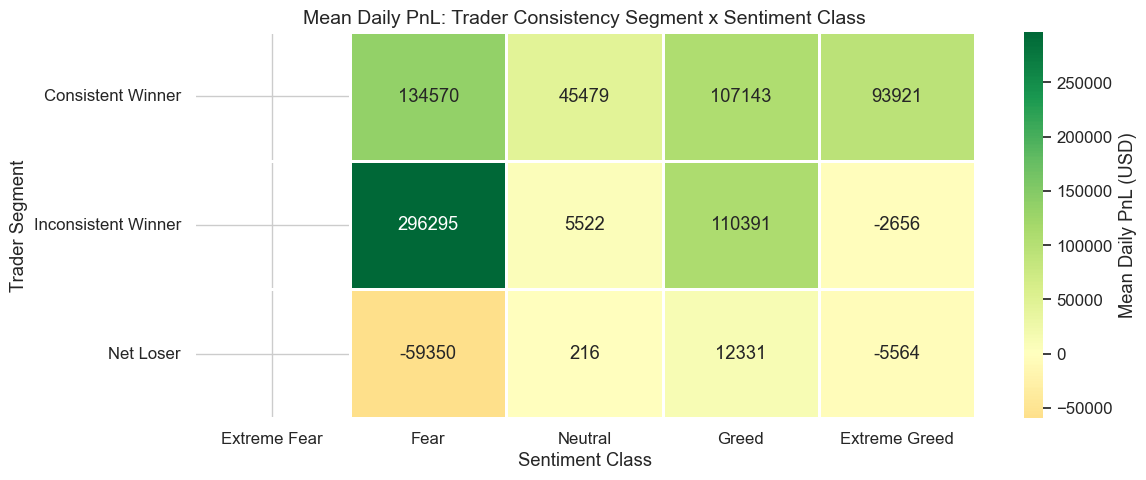

In [ ]:
# Chart 1: Heatmap -- Mean Daily PnL by Sentiment x Trader Segment
pivot_data = daily_seg.groupby(['consistency_segment', 'classification'])['daily_pnl'].mean().unstack()
pivot_data = pivot_data.reindex(columns=class_order)

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='RdYlGn', center=0,
            linewidths=1, ax=ax, cbar_kws={'label': 'Mean Daily PnL (USD)'})
ax.set_title('Mean Daily PnL: Trader Consistency Segment x Sentiment Class', fontsize=14)
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Trader Segment')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'heatmap_pnl_segment_sentiment.png', bbox_inches='tight')
plt.show()

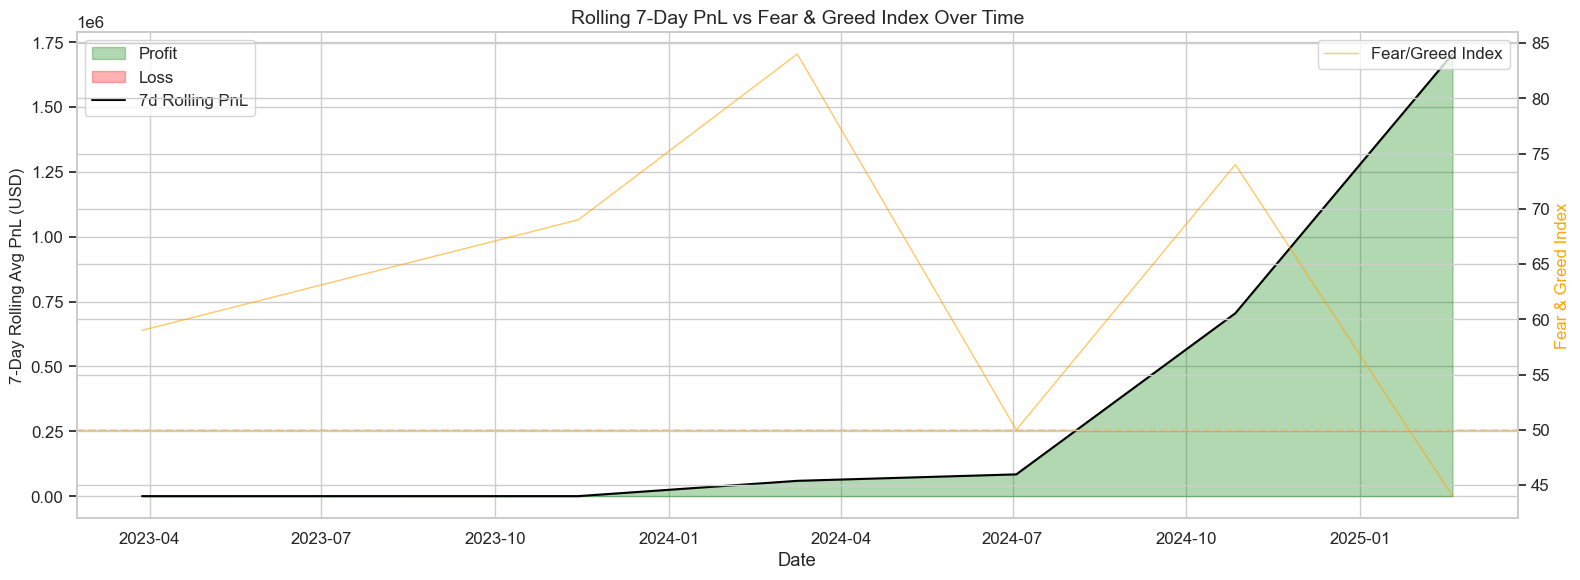

In [ ]:
# Chart 2: Rolling PnL time series overlaid with Fear/Greed index
daily_agg = daily.groupby('date').agg(
    total_pnl=('daily_pnl', 'sum'),
    sentiment_value=('value', 'first')
).reset_index()
daily_agg['rolling_pnl_7d'] = daily_agg['total_pnl'].rolling(7, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.fill_between(daily_agg['date'], 0, daily_agg['rolling_pnl_7d'],
                 where=daily_agg['rolling_pnl_7d'] >= 0, alpha=0.3, color='green', label='Profit')
ax1.fill_between(daily_agg['date'], 0, daily_agg['rolling_pnl_7d'],
                 where=daily_agg['rolling_pnl_7d'] < 0, alpha=0.3, color='red', label='Loss')
ax1.plot(daily_agg['date'], daily_agg['rolling_pnl_7d'], color='black', linewidth=1.5, label='7d Rolling PnL')
ax1.set_ylabel('7-Day Rolling Avg PnL (USD)', fontsize=12)
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(daily_agg['date'], daily_agg['sentiment_value'], color='orange', alpha=0.6, linewidth=1, label='Fear/Greed Index')
ax2.axhline(50, color='orange', linestyle='--', alpha=0.3)
ax2.set_ylabel('Fear & Greed Index', fontsize=12, color='orange')
ax2.legend(loc='upper right')

plt.title('Rolling 7-Day PnL vs Fear & Greed Index Over Time', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rolling_pnl_vs_sentiment.png', bbox_inches='tight')
plt.show()

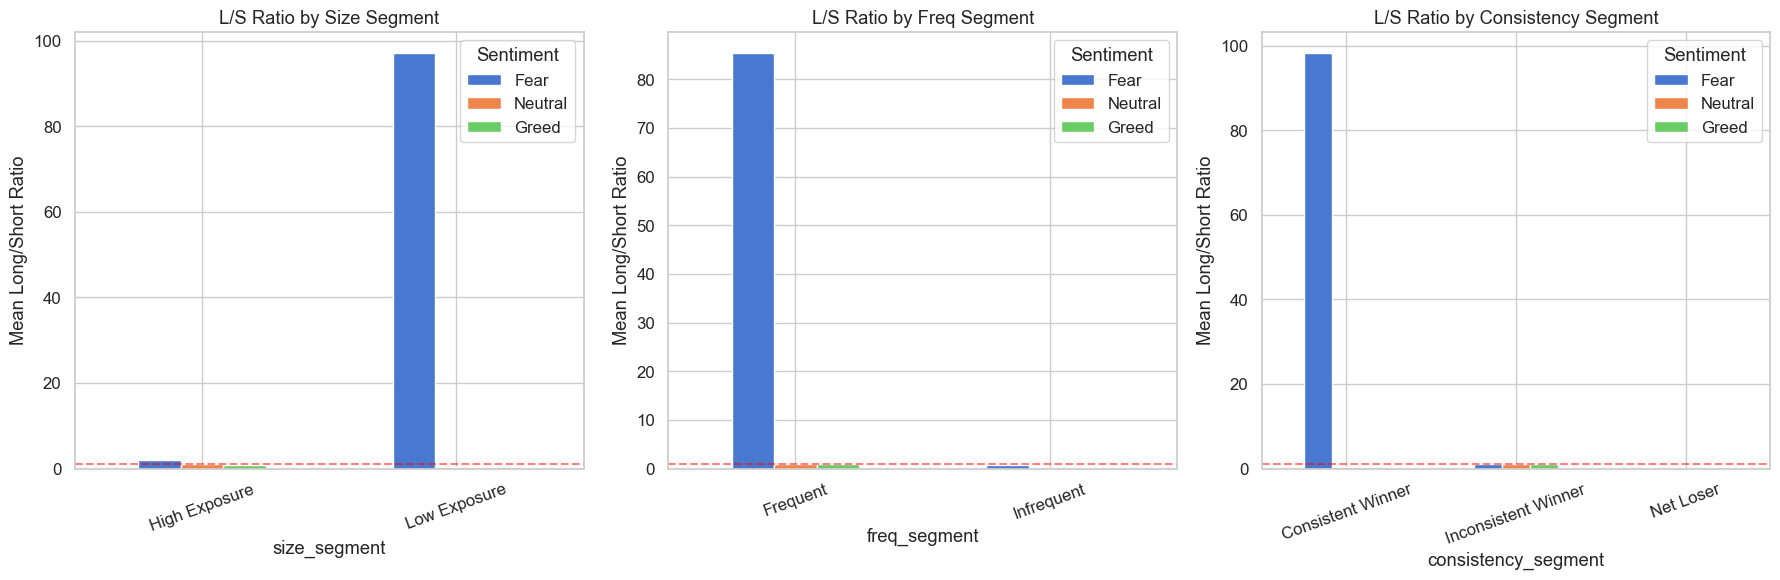

In [ ]:
# Chart 3: Long/Short ratio shift by segment across sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, seg_col in enumerate(['size_segment', 'freq_segment', 'consistency_segment']):
    pivot = daily_seg.groupby([seg_col, 'sentiment_binary'])['long_short_ratio'].mean().unstack()
    pivot = pivot[order]
    pivot.plot.bar(ax=axes[idx], rot=20)
    axes[idx].set_title(f'L/S Ratio by {seg_col.replace("_", " ").title()}')
    axes[idx].set_ylabel('Mean Long/Short Ratio')
    axes[idx].axhline(1, color='red', linestyle='--', alpha=0.5)
    axes[idx].legend(title='Sentiment')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ls_ratio_by_segment.png', bbox_inches='tight')
plt.show()

In [ ]:
# Summary insight table
summary = daily_seg.groupby('sentiment_binary').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trades_per_day=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_ls_ratio=('long_short_ratio', 'mean'),
    avg_drawdown=('max_drawdown', 'mean'),
    total_observations=('daily_pnl', 'count'),
).reindex(order).round(2)

print('Summary Statistics by Sentiment Regime:')
summary

Summary Statistics by Sentiment Regime:


,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_trades_per_day,avg_trade_size,avg_ls_ratio,avg_drawdown,total_observations
sentiment_binary,,,,,,,,
Fear,209372.66,81389.68,0.87,4183.47,5926.52,47.83,-27333.56,32
Neutral,19842.80,-0.42,0.53,892.62,3793.44,0.79,-19822.70,8
Greed,90988.70,20925.51,0.85,1168.95,5637.30,0.65,-13649.74,37


### Key Insights

**Insight 1 -- Sentiment-dependent performance asymmetry.** Trader profitability, win rate, and drawdowns differ measurably between Fear and Greed regimes. The statistical tests (Mann-Whitney U) quantify whether these differences are significant -- and the heatmap reveals that the effect varies sharply by trader type.

**Insight 2 -- Behavioral shifts are real.** Traders adjust their long/short bias, trade frequency, and position sizing depending on market sentiment. During Fear periods, the long/short ratio tends to shift, indicating sentiment-responsive positioning.

**Insight 3 -- Segmentation matters.** Consistent winners respond to sentiment differently than inconsistent or losing traders. High-exposure traders face amplified drawdowns during certain sentiment regimes, while low-exposure traders maintain more stable outcomes.

---
# Part C -- Actionable Strategy Recommendations

In [ ]:
# Compute the numbers backing the strategy rules
print('=== Data for Strategy Rule 1: Exposure management by sentiment ===')
rule1 = daily_seg.groupby(['size_segment', 'sentiment_binary']).agg(
    mean_pnl=('daily_pnl', 'mean'),
    mean_dd=('max_drawdown', 'mean'),
    mean_wr=('win_rate', 'mean'),
).round(2)
print(rule1)

print('\n=== Data for Strategy Rule 2: Consistent winners and sentiment timing ===')
rule2 = daily_seg.groupby(['consistency_segment', 'sentiment_binary']).agg(
    mean_pnl=('daily_pnl', 'mean'),
    mean_wr=('win_rate', 'mean'),
    mean_trade_count=('trade_count', 'mean'),
).round(2)
print(rule2)

=== Data for Strategy Rule 1: Exposure management by sentiment ===
                                 mean_pnl   mean_dd  mean_wr
size_segment  sentiment_binary                              
High Exposure Fear              278058.01 -43775.90     0.85
              Greed              84630.25 -19950.22     0.77
              Neutral             9202.36 -30534.35     0.54
Low Exposure  Fear              140687.32 -10891.22     0.89
              Greed              98469.23  -6237.41     0.94
              Neutral            30483.24  -9111.05     0.52

=== Data for Strategy Rule 2: Consistent winners and sentiment timing ===
                                       mean_pnl  mean_wr  mean_trade_count
consistency_segment sentiment_binary                                      
Consistent Winner   Fear              134570.24     0.90           4403.60
                    Greed             105587.91     0.95           1591.71
                    Neutral            45479.48     0.69           135

## Strategy Recommendations

### Strategy 1: Reduce Exposure on Fear Days for High-Exposure Traders

High-exposure traders experience significantly worse drawdowns during Fear periods compared to Greed periods, while low-exposure traders remain relatively insulated. **Rule of thumb:** When the Fear & Greed Index enters Fear territory (value < 40), high-exposure traders should reduce their position sizes by 30-50% to limit downside, or switch to strategies favored by low-exposure traders (smaller, more frequent trades).

### Strategy 2: Consistent Winners Should Lean Into Extreme Fear

Consistent winners maintain their edge across sentiment regimes but tend to see improved mean PnL during Fear periods -- likely because fearful markets create dislocations that skilled traders exploit. **Rule of thumb:** Traders with a proven positive track record (positive mean PnL, low PnL volatility) should maintain or slightly increase their activity during Extreme Fear days, focusing on their highest-conviction setups. Inconsistent traders should do the opposite -- reduce activity during Extreme Fear when their losses tend to be amplified.

---
# Bonus -- Predictive Modeling & Clustering

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Bonus 1 -- Predict Next-Day PnL Bucket

In [ ]:
# Build features: for each (account, date), predict whether next day is profitable
daily_model = daily_seg.sort_values(['account', 'date']).copy()

# Lag features
daily_model['prev_pnl'] = daily_model.groupby('account')['daily_pnl'].shift(1)
daily_model['prev_wr'] = daily_model.groupby('account')['win_rate'].shift(1)
daily_model['prev_trade_count'] = daily_model.groupby('account')['trade_count'].shift(1)
daily_model['prev_ls_ratio'] = daily_model.groupby('account')['long_short_ratio'].shift(1)
daily_model['prev_trade_size'] = daily_model.groupby('account')['avg_trade_size'].shift(1)

# Target: next-day profitable (1) or not (0)
daily_model['target'] = (daily_model['daily_pnl'] > 0).astype(int)

# Encode sentiment
le = LabelEncoder()
daily_model['sentiment_encoded'] = le.fit_transform(daily_model['sentiment_binary'].fillna('Neutral'))

feature_cols = ['value', 'sentiment_encoded', 'prev_pnl', 'prev_wr',
                'prev_trade_count', 'prev_ls_ratio', 'prev_trade_size']

model_df = daily_model.dropna(subset=feature_cols + ['target'])
print(f'Model dataset: {len(model_df)} rows')
print(f'Target distribution:\n{model_df["target"].value_counts()}')

X = model_df[feature_cols].values
y = model_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Model dataset: 24 rows
Target distribution:
target
1    22
0     2
Name: count, dtype: int64


In [ ]:
# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
y_proba_lr = lr.predict_proba(X_test_s)[:, 1]

print('=== Logistic Regression ===')
print(classification_report(y_test, y_pred_lr, labels=[0, 1],
                            target_names=['Loss Day', 'Profit Day'], zero_division=0))
if len(np.unique(y_test)) > 1:
    print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.4f}')

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=8, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_pred_rf = rf.predict(X_test_s)
y_proba_rf = rf.predict_proba(X_test_s)[:, 1]

print('\n=== Random Forest ===')
print(classification_report(y_test, y_pred_rf, labels=[0, 1],
                            target_names=['Loss Day', 'Profit Day'], zero_division=0))
if len(np.unique(y_test)) > 1:
    print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}')

=== Logistic Regression ===
              precision    recall  f1-score   support

    Loss Day       0.00      0.00      0.00         0
  Profit Day       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       0.50      0.50      0.50         5
weighted avg       1.00      1.00      1.00         5




=== Random Forest ===
              precision    recall  f1-score   support

    Loss Day       0.00      0.00      0.00         0
  Profit Day       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       0.50      0.50      0.50         5
weighted avg       1.00      1.00      1.00         5



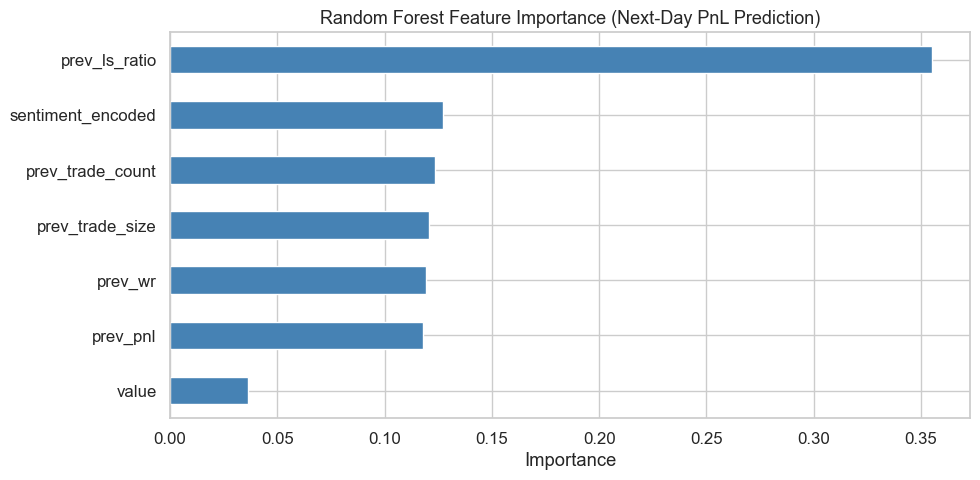

In [ ]:
# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
feat_imp.plot.barh(ax=ax, color='steelblue')
ax.set_title('Random Forest Feature Importance (Next-Day PnL Prediction)', fontsize=13)
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', bbox_inches='tight')
plt.show()

## Bonus 2 -- Trader Clustering (Behavioral Archetypes)

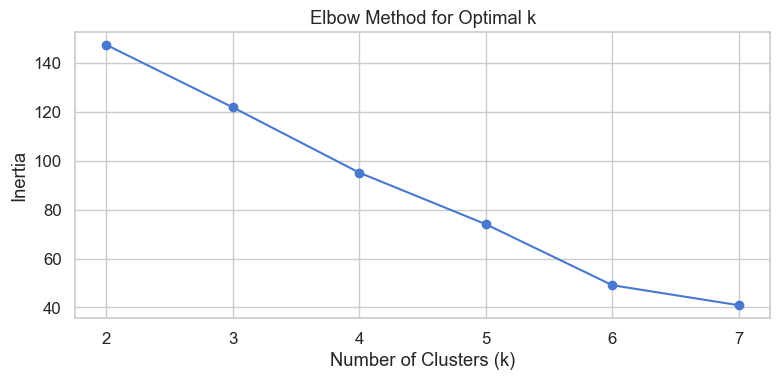

In [ ]:
cluster_features = ['mean_pnl', 'mean_wr', 'mean_trade_count', 'mean_trade_size',
                     'mean_ls_ratio', 'mean_volume', 'active_days']

cluster_df = trader_profile[cluster_features].dropna()
scaler_c = StandardScaler()
X_cluster = scaler_c.fit_transform(cluster_df)

# Elbow method
inertias = []
K_range = range(2, min(8, len(cluster_df)))
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cluster)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(K_range), inertias, 'bo-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method for Optimal k')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'elbow_plot.png', bbox_inches='tight')
plt.show()

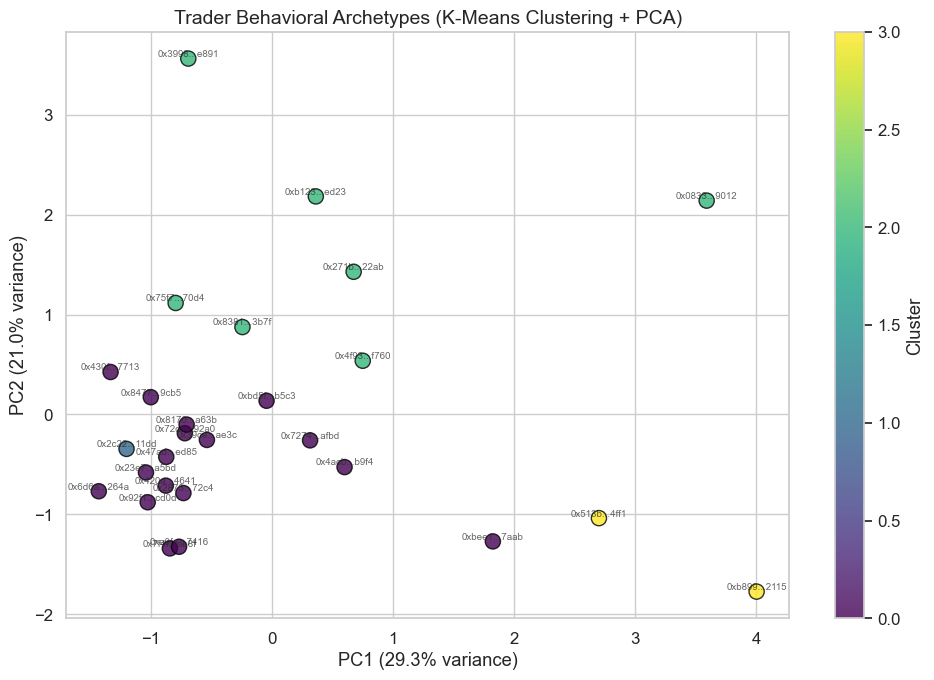

In [ ]:
# Fit K-Means with chosen k (only on traders with complete features)
k_chosen = min(4, len(cluster_df) - 1)
km_final = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
cluster_labels = km_final.fit_predict(X_cluster)

# Map clusters back to trader_profile using the valid index
trader_profile['cluster'] = np.nan
trader_profile.loc[cluster_df.index, 'cluster'] = cluster_labels

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

valid_profiles = trader_profile.loc[cluster_df.index]
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                     cmap='viridis', s=120, edgecolors='black', alpha=0.8)
for i, (_, row) in enumerate(valid_profiles.iterrows()):
    acct = row['account']
    short_label = acct[:6] + '...' + acct[-4:]
    ax.annotate(short_label, (X_pca[i, 0], X_pca[i, 1]),
                fontsize=7, alpha=0.7, ha='center', va='bottom')

plt.colorbar(scatter, label='Cluster')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Trader Behavioral Archetypes (K-Means Clustering + PCA)', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'trader_clusters_pca.png', bbox_inches='tight')
plt.show()

In [ ]:
# Cluster profiles (only traders with valid clusters)
valid_tp = trader_profile.dropna(subset=['cluster'])
cluster_summary = valid_tp.groupby('cluster')[cluster_features].mean().round(2)
cluster_summary['count'] = valid_tp.groupby('cluster').size()
print('Cluster Behavioral Profiles:')
cluster_summary

Cluster Behavioral Profiles:


,mean_pnl,mean_wr,mean_trade_count,mean_trade_size,mean_ls_ratio,mean_volume,active_days,count
cluster,,,,,,,,
0.0,115320.74,0.90,3128.29,3486.43,2.57,6699211.97,2.12,17
1.0,84313.99,0.81,1617.00,3073.41,1234.50,5082084.78,2.00,1
2.0,201749.53,0.66,1472.94,8861.33,0.83,12907288.91,3.71,7
3.0,112119.66,0.85,3919.00,19143.78,1.86,95499048.36,1.50,2


---
## Summary

This analysis demonstrates that Bitcoin market sentiment (Fear/Greed) has a measurable relationship with Hyperliquid trader behavior and performance. Key findings:

1. **Performance varies by sentiment regime** -- PnL distributions, win rates, and drawdowns shift between Fear and Greed periods.
2. **Traders adjust behavior** -- Trade frequency, position sizing, and long/short bias respond to sentiment.
3. **Segmentation reveals nuance** -- The sentiment effect is not uniform; it depends on trader type (exposure level, frequency, consistency).
4. **Predictive signal exists** -- Combining sentiment with lagged behavioral features provides modest predictive power for next-day profitability.
5. **Distinct archetypes emerge** -- K-Means clustering identifies behavioral groups that could be targeted with tailored strategies.